In [1]:
from CherryTreeDataset import CherryTreeDataset
from torchvision import transforms
from aux import plot_spectra
from resnet_adapters import adapt_resnet_channels
import torch
from torch.utils.data import DataLoader
import torchvision.models as models
from torchvision.models import ResNet18_Weights, ResNet50_Weights, SqueezeNet1_1_Weights
from sklearn.metrics import confusion_matrix
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import torch.nn as nn



here


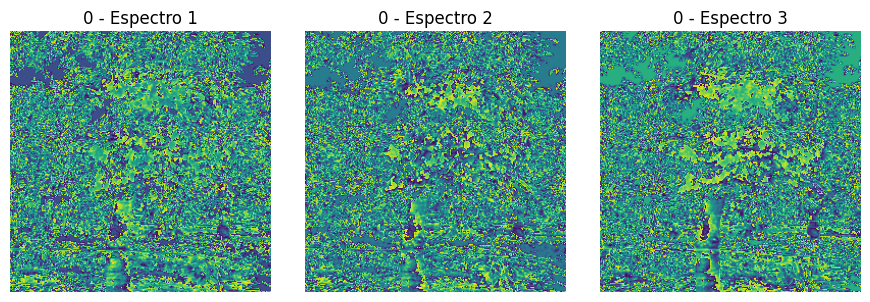

Number of samples for Healthy: 412
Number of samples for Disease: 206


In [2]:
# Define las transformaciones si son necesarias
transform = transforms.Compose([
    transforms.Resize((256,256)),
    #transforms.Resize((1280, 960)),
    transforms.ToTensor()
])

#formats = ('RGB.JPG', 'RED.TIF','GRE.TIF','NIR.TIF','REG.TIF')
#formats = ('RGB.JPG','NIR.TIF','REG.TIF')
formats = ('RGB.JPG',)
dataset = CherryTreeDataset('/mnt/d/Maestria/tfm/7144071', transform=transform, formats = formats, concatenate = True, healthy_ratio=2)
images, label = dataset[1]  
plot_spectra(images, label)
dataset.print_class_counts()

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f'El dispositivo seleccionado es {device}')

El dispositivo seleccionado es cuda


In [4]:
train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size
train_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_size, test_size])

# DataLoader para manejar los lotes de datos
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True, num_workers=20)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=True, num_workers=20)

#resnet = models.squeezenet1_1(SqueezeNet1_1_Weights.IMAGENET1K_V1)
resnet = models.resnet18(weights=ResNet18_Weights.IMAGENET1K_V1)
#resnet = models.resnet50(weights=ResNet50_Weights.IMAGENET1K_V1)
# Adapta el modelo para aceptar 4 canales
#resnet = adapt_resnet_channels(resnet, 7)

print(resnet)


num_classes = 2  # Número de clases en tu dataset
resnet.fc = nn.Sequential(
    nn.Dropout(0.5),  # Añade dropout con una probabilidad de 0.5
    nn.Linear(resnet.fc.in_features, 128),  # Primera reducción a 64
    nn.ReLU(),
    nn.Dropout(0.5),  # Añade dropout con una probabilidad de 0.5
    nn.Linear(128, 32),  # Primera reducción a 64
    nn.ReLU(),
    nn.Dropout(0.5),  # Añade dropout con una probabilidad de 0.5
    nn.Linear(32, 1),
)
resnet.to(device)

for param in resnet.parameters():
    param.requires_grad = False


# Descongelar todas las capas en `layer4`
for param in resnet.layer4.parameters():
    param.requires_grad = True
for param in resnet.layer3.parameters():
    param.requires_grad = True
#for param in resnet.conv1.parameters():
#    param.requires_grad = True

# Descongelar la capa `avgpool` y `fc`
for param in resnet.avgpool.parameters():
    param.requires_grad = True

for param in resnet.fc.parameters():
    param.requires_grad = True

print(resnet)
#for name, param in resnet.named_parameters():
 #   print(f"{name}: requires_grad={param.requires_grad}")



ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

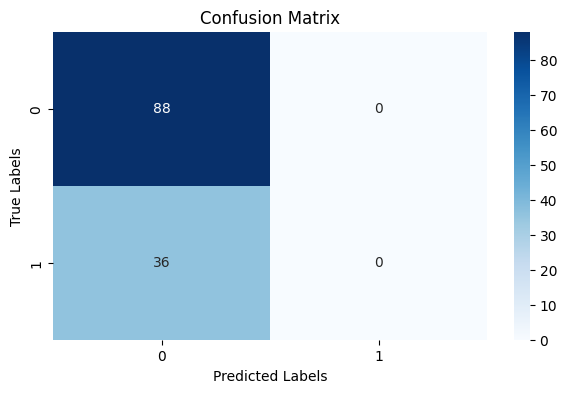

Epoch [1/50], Train Loss: 0.6563, Validation Loss: 0.6426, Accuracy: 70.97%


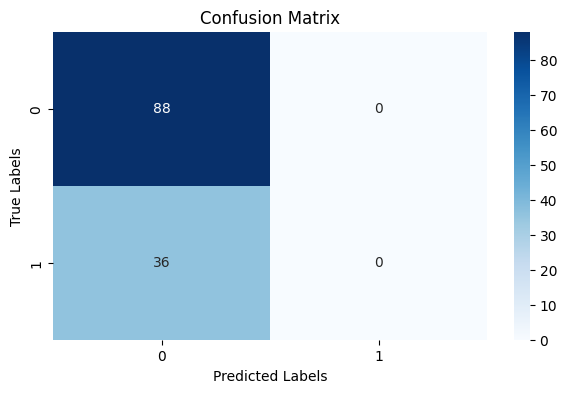

Epoch [2/50], Train Loss: 0.6525, Validation Loss: 0.6243, Accuracy: 70.97%


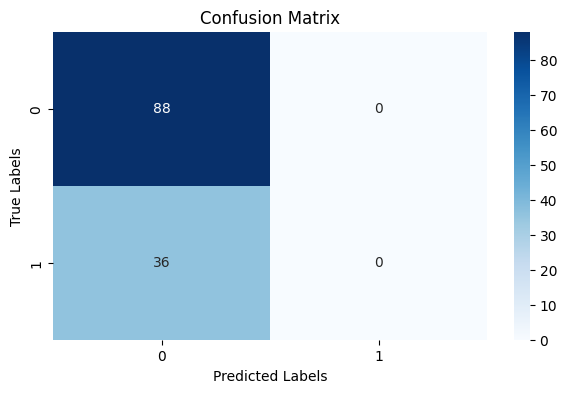

Epoch [3/50], Train Loss: 0.6249, Validation Loss: 0.6037, Accuracy: 70.97%


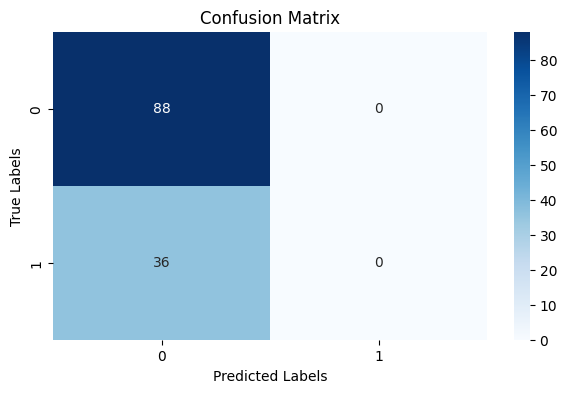

Epoch [4/50], Train Loss: 0.6045, Validation Loss: 0.5882, Accuracy: 70.97%


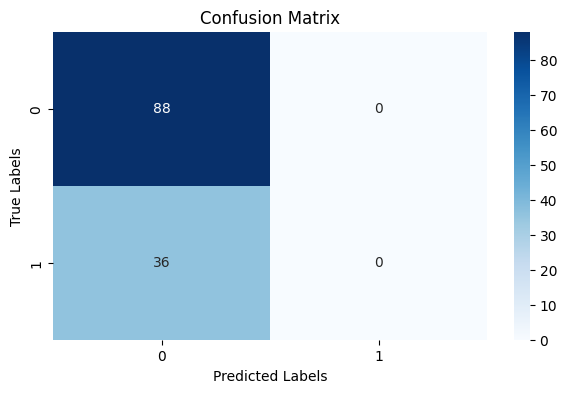

Epoch [5/50], Train Loss: 0.5851, Validation Loss: 0.5590, Accuracy: 70.97%


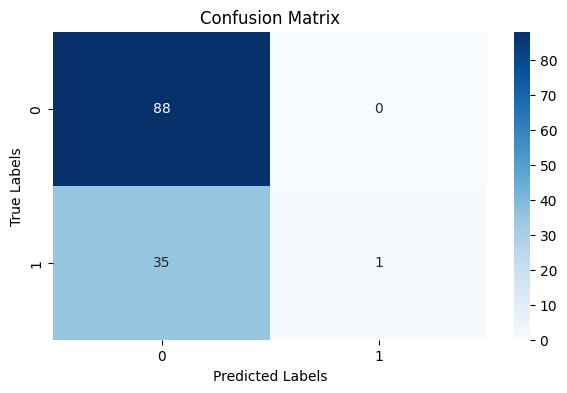

Epoch [6/50], Train Loss: 0.5403, Validation Loss: 0.5456, Accuracy: 71.77%


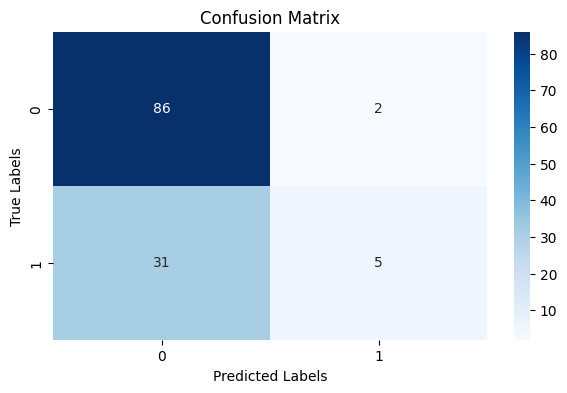

Epoch [7/50], Train Loss: 0.5150, Validation Loss: 0.5299, Accuracy: 73.39%


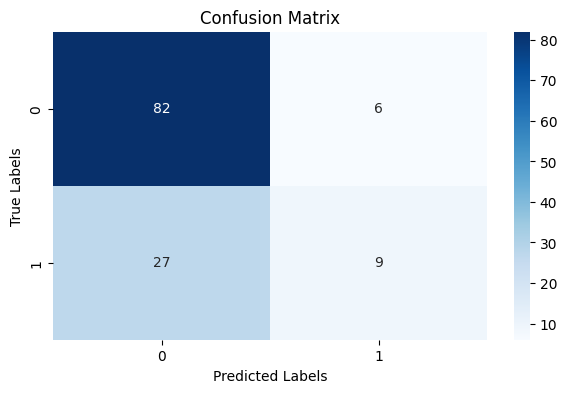

Epoch [8/50], Train Loss: 0.4687, Validation Loss: 0.5076, Accuracy: 73.39%


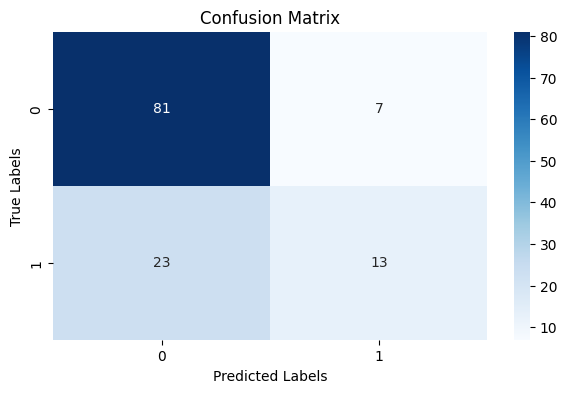

Epoch [9/50], Train Loss: 0.4189, Validation Loss: 0.5099, Accuracy: 75.81%


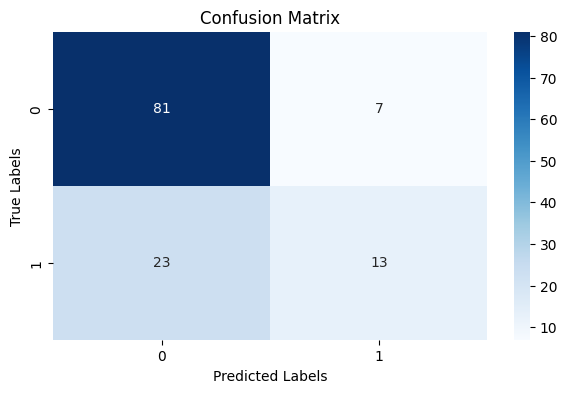

Epoch [10/50], Train Loss: 0.3685, Validation Loss: 0.4991, Accuracy: 75.81%


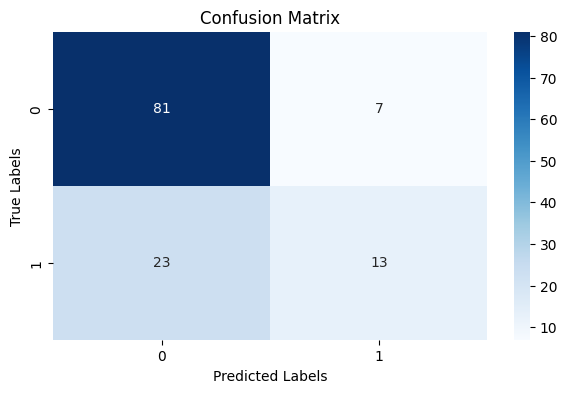

Epoch [11/50], Train Loss: 0.3250, Validation Loss: 0.4863, Accuracy: 75.81%


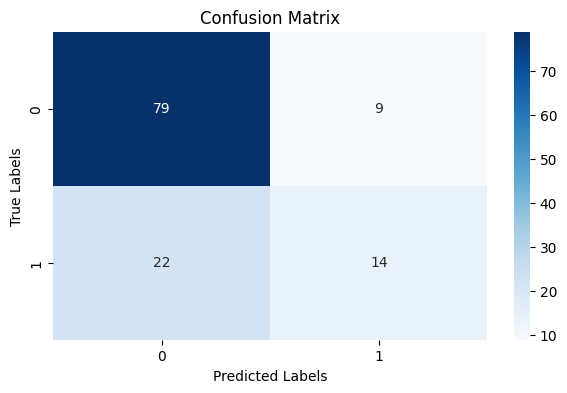

Epoch [12/50], Train Loss: 0.2744, Validation Loss: 0.4756, Accuracy: 75.00%


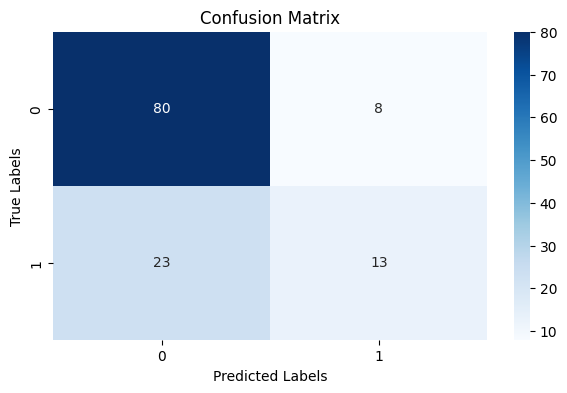

Epoch [13/50], Train Loss: 0.2382, Validation Loss: 0.4707, Accuracy: 75.00%


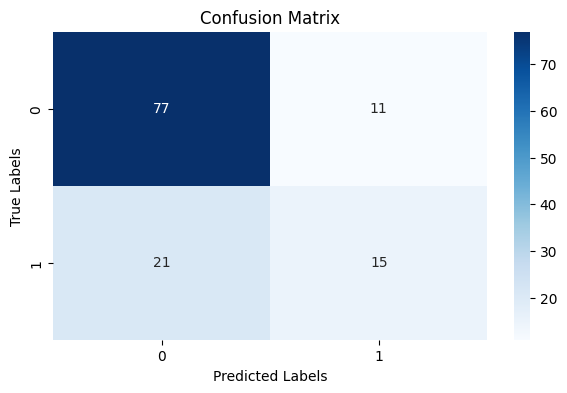

Epoch [14/50], Train Loss: 0.2093, Validation Loss: 0.4728, Accuracy: 74.19%


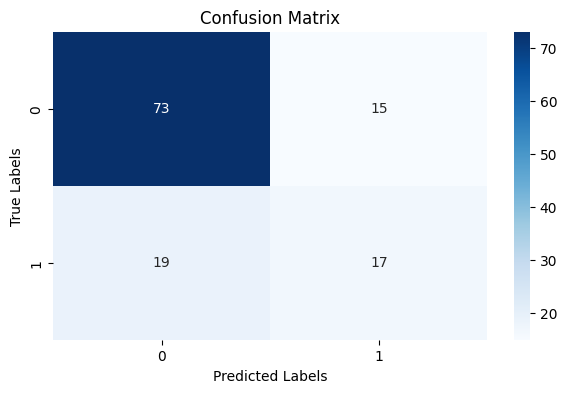

Epoch [15/50], Train Loss: 0.1747, Validation Loss: 0.4838, Accuracy: 72.58%


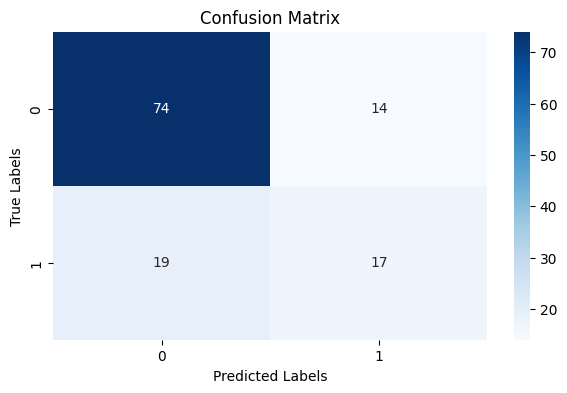

Epoch [16/50], Train Loss: 0.1470, Validation Loss: 0.5003, Accuracy: 73.39%


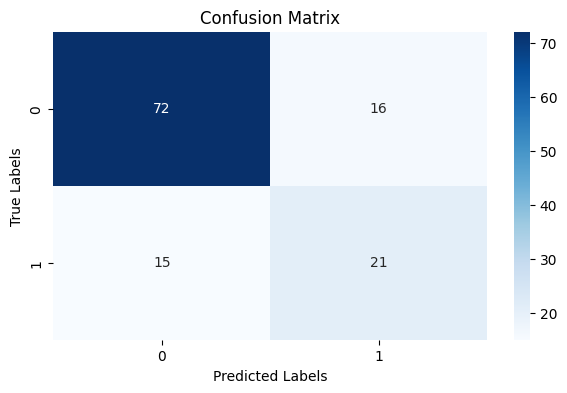

Epoch [17/50], Train Loss: 0.1255, Validation Loss: 0.5068, Accuracy: 75.00%


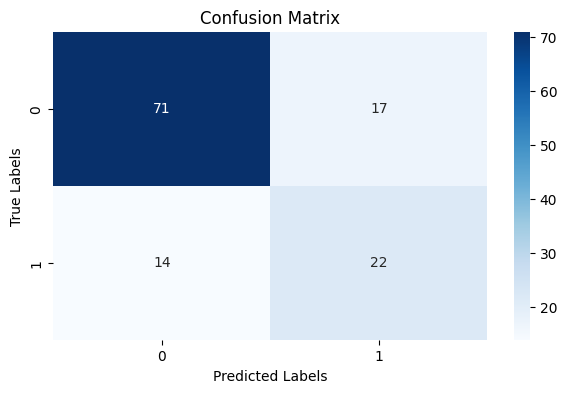

Epoch [18/50], Train Loss: 0.1272, Validation Loss: 0.4994, Accuracy: 75.00%


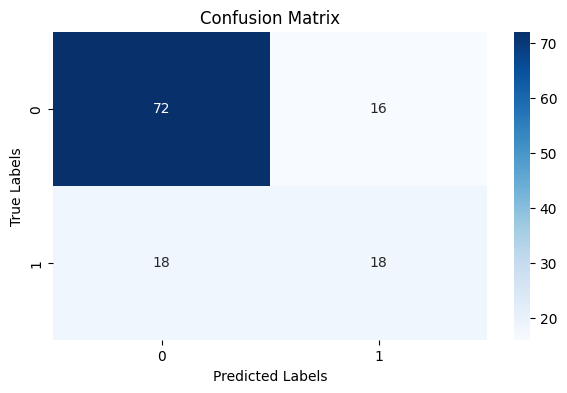

Epoch [19/50], Train Loss: 0.0914, Validation Loss: 0.5278, Accuracy: 72.58%


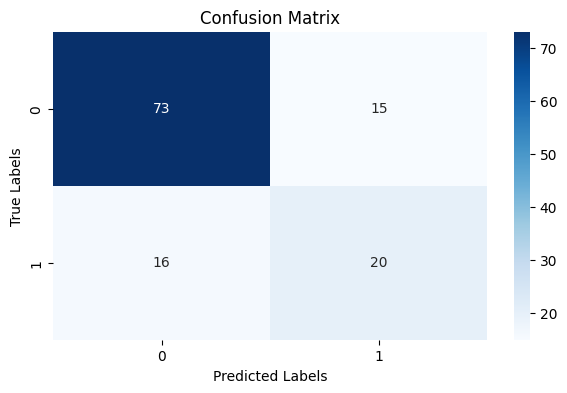

Epoch [20/50], Train Loss: 0.0869, Validation Loss: 0.5369, Accuracy: 75.00%


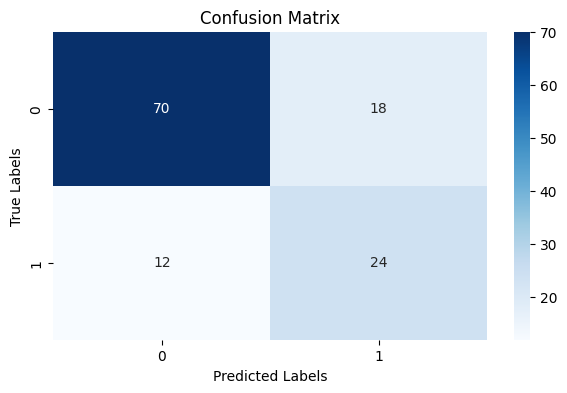

Epoch [21/50], Train Loss: 0.0858, Validation Loss: 0.5485, Accuracy: 75.81%


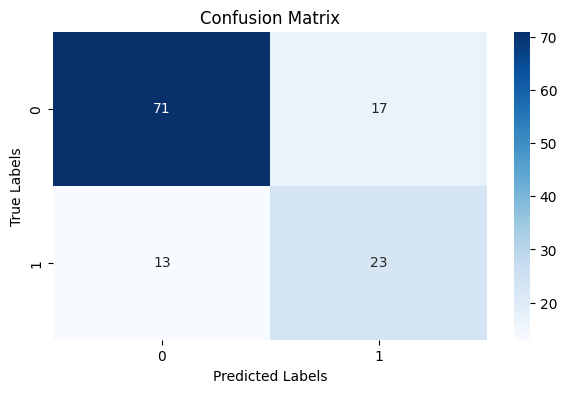

Epoch [22/50], Train Loss: 0.0758, Validation Loss: 0.5639, Accuracy: 75.81%


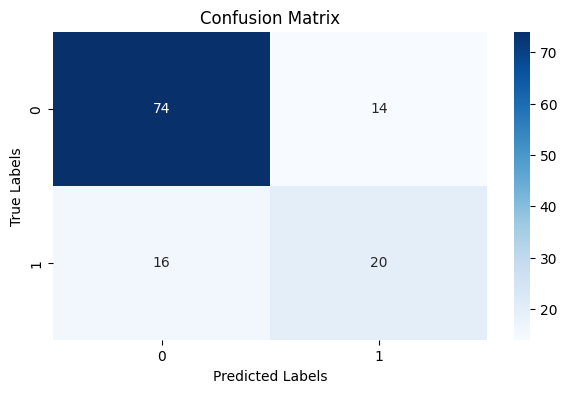

Epoch [23/50], Train Loss: 0.0686, Validation Loss: 0.5512, Accuracy: 75.81%


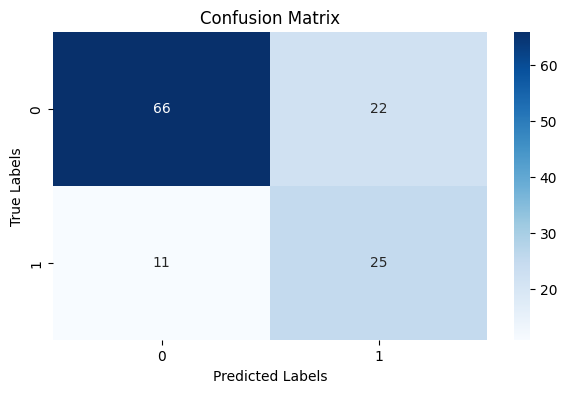

Epoch [24/50], Train Loss: 0.0652, Validation Loss: 0.5921, Accuracy: 73.39%


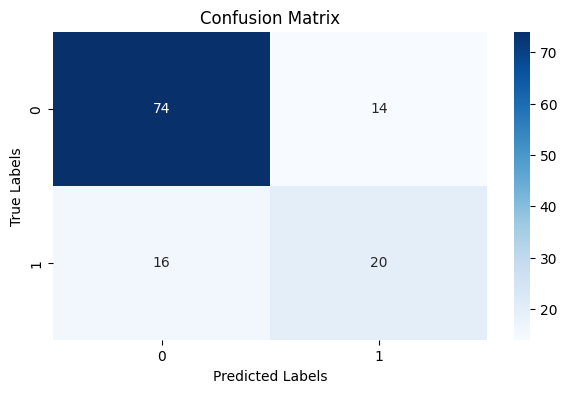

Epoch [25/50], Train Loss: 0.0524, Validation Loss: 0.5876, Accuracy: 75.81%


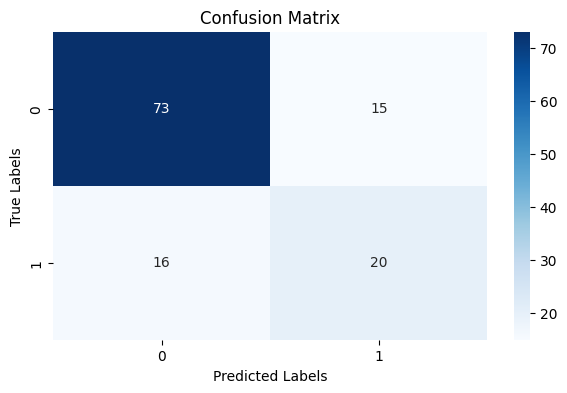

Epoch [26/50], Train Loss: 0.0509, Validation Loss: 0.5993, Accuracy: 75.00%


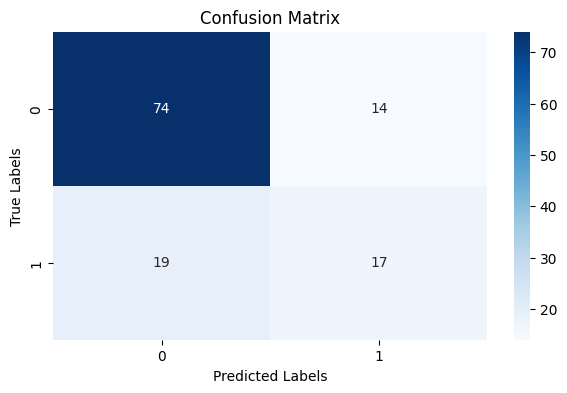

Epoch [27/50], Train Loss: 0.0542, Validation Loss: 0.7487, Accuracy: 73.39%


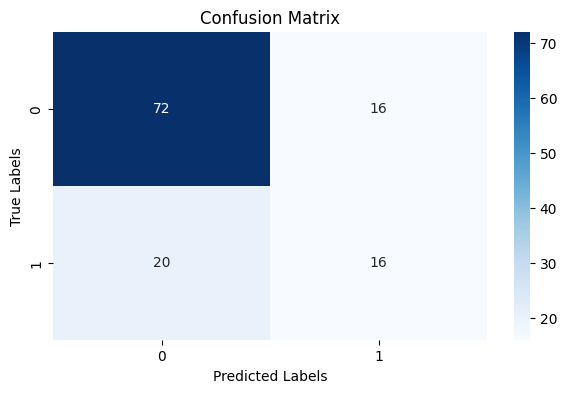

Epoch [28/50], Train Loss: 0.0621, Validation Loss: 0.6984, Accuracy: 70.97%


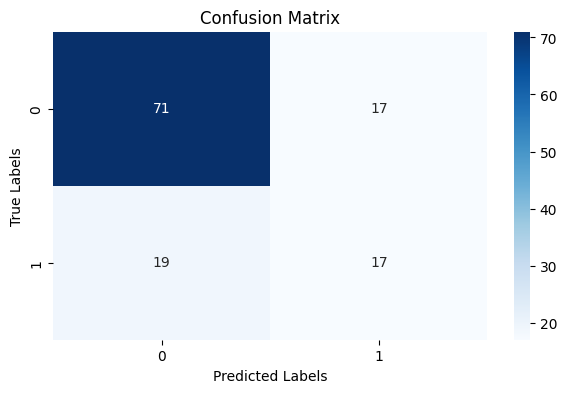

Epoch [29/50], Train Loss: 0.0392, Validation Loss: 0.6616, Accuracy: 70.97%


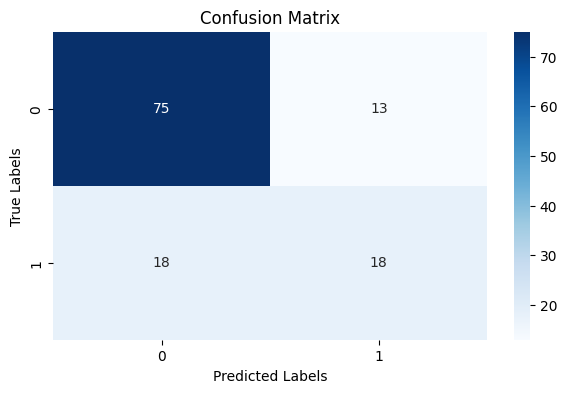

Epoch [30/50], Train Loss: 0.0349, Validation Loss: 0.7008, Accuracy: 75.00%


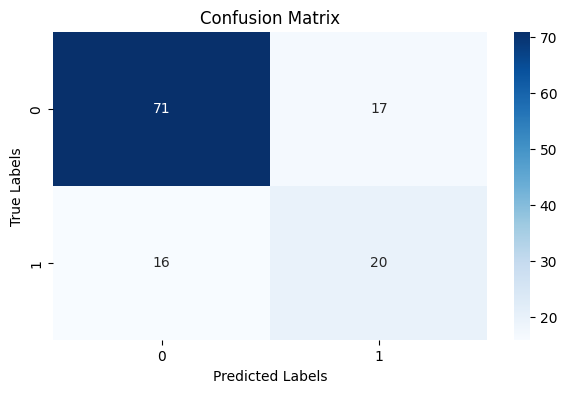

Epoch [31/50], Train Loss: 0.0348, Validation Loss: 0.6976, Accuracy: 73.39%


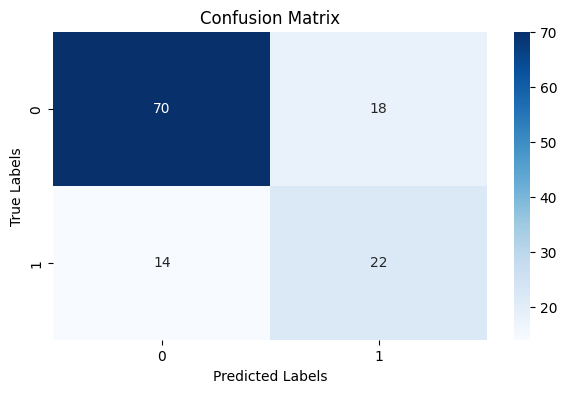

Epoch [32/50], Train Loss: 0.0387, Validation Loss: 0.7574, Accuracy: 74.19%


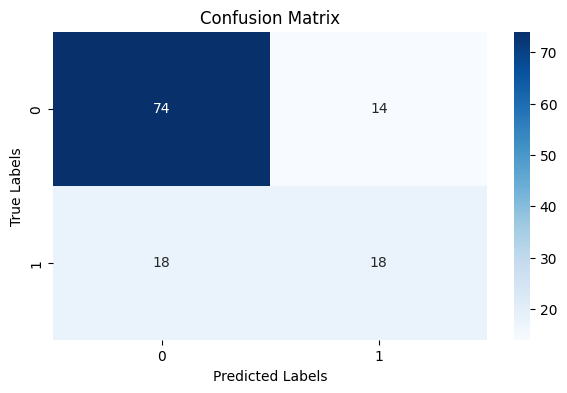

Epoch [33/50], Train Loss: 0.0334, Validation Loss: 0.6901, Accuracy: 74.19%


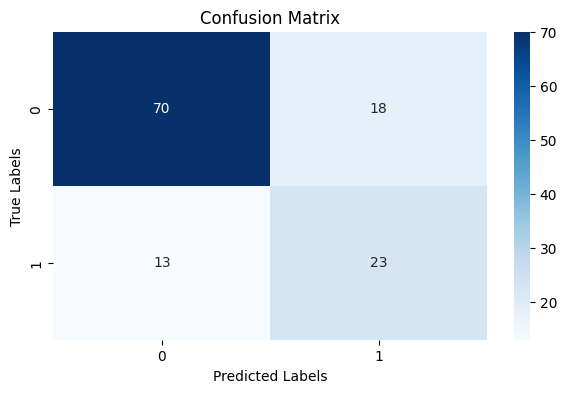

Epoch [34/50], Train Loss: 0.0402, Validation Loss: 0.7459, Accuracy: 75.00%


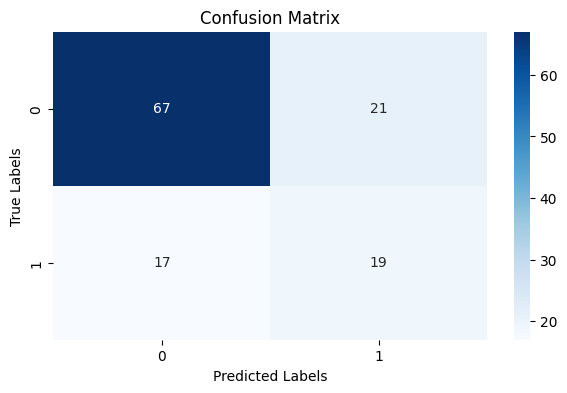

Epoch [35/50], Train Loss: 0.0281, Validation Loss: 0.8237, Accuracy: 69.35%


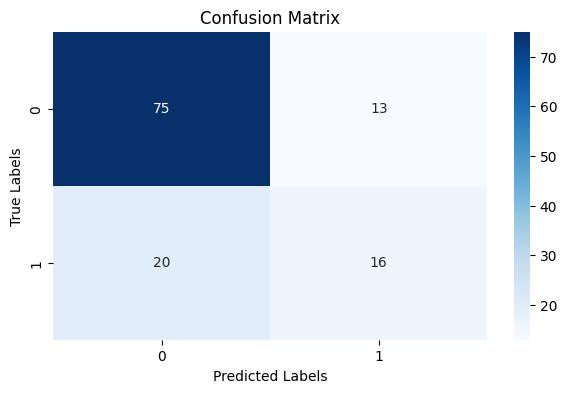

Epoch [36/50], Train Loss: 0.0409, Validation Loss: 0.7703, Accuracy: 73.39%


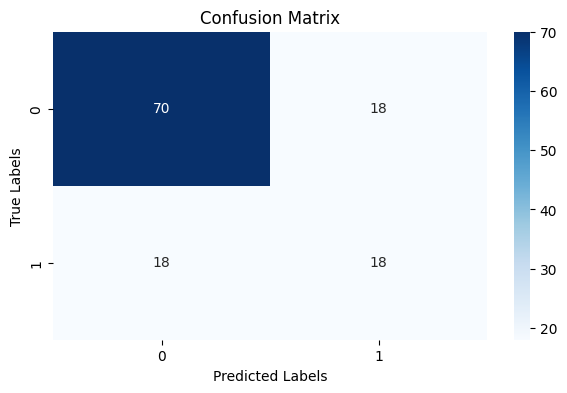

Epoch [37/50], Train Loss: 0.0306, Validation Loss: 0.7492, Accuracy: 70.97%


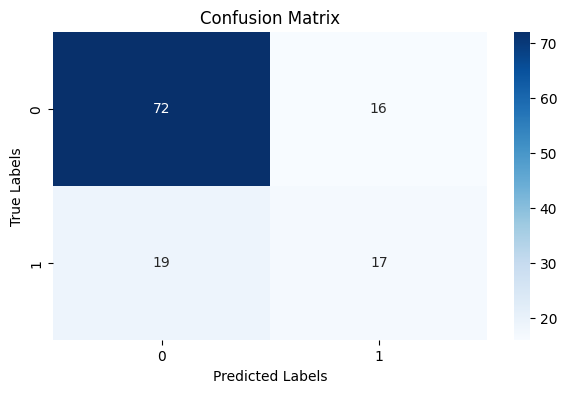

Epoch [38/50], Train Loss: 0.0242, Validation Loss: 0.8473, Accuracy: 71.77%


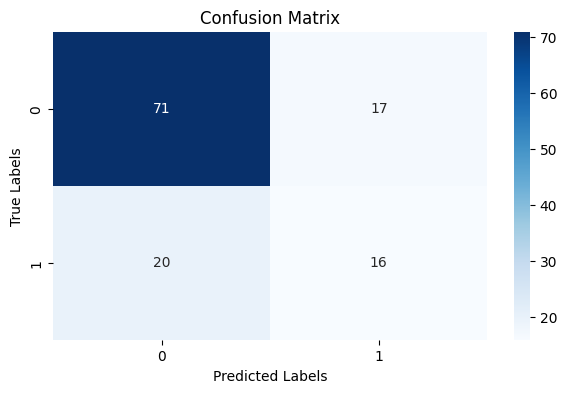

Epoch [39/50], Train Loss: 0.0199, Validation Loss: 0.8010, Accuracy: 70.16%


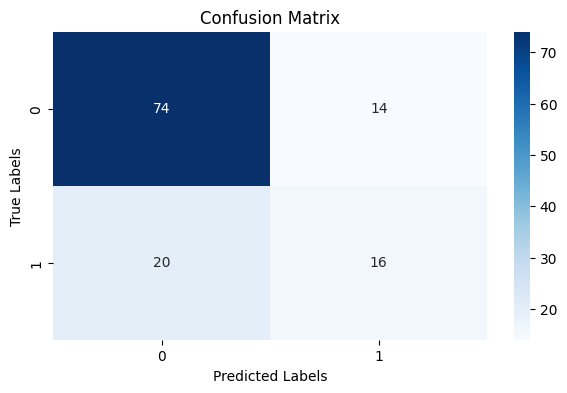

Epoch [40/50], Train Loss: 0.0167, Validation Loss: 0.7871, Accuracy: 72.58%


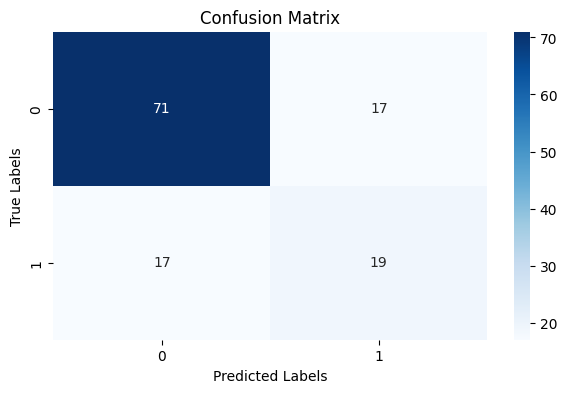

Epoch [41/50], Train Loss: 0.0202, Validation Loss: 0.7643, Accuracy: 72.58%


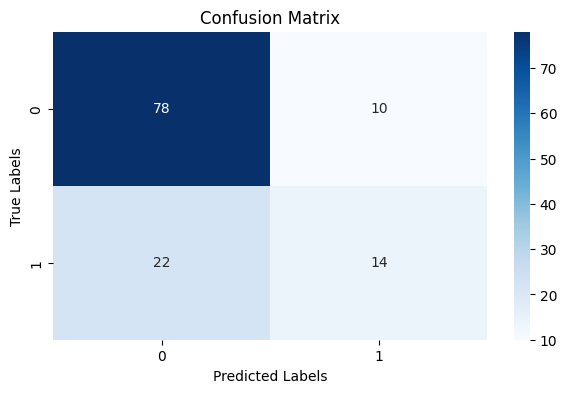

Epoch [42/50], Train Loss: 0.0199, Validation Loss: 0.9533, Accuracy: 74.19%


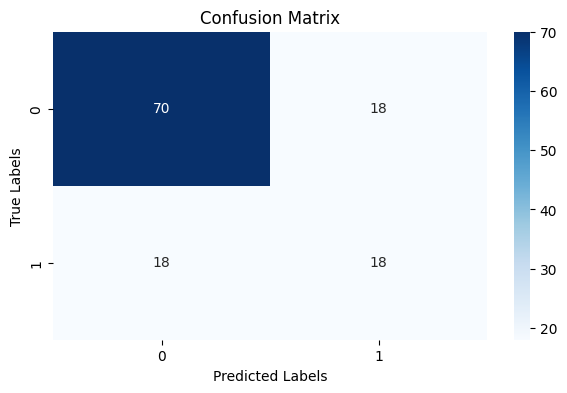

Epoch [43/50], Train Loss: 0.0175, Validation Loss: 0.8537, Accuracy: 70.97%


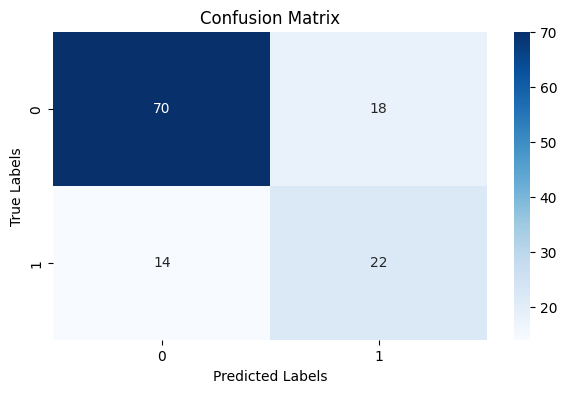

Epoch [44/50], Train Loss: 0.0208, Validation Loss: 0.8824, Accuracy: 74.19%


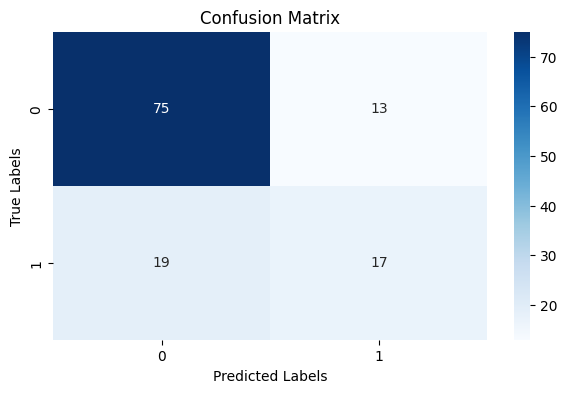

Epoch [45/50], Train Loss: 0.0174, Validation Loss: 0.8979, Accuracy: 74.19%


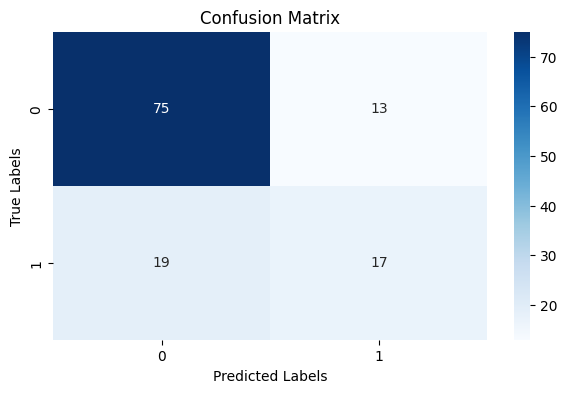

Epoch [46/50], Train Loss: 0.0146, Validation Loss: 0.8874, Accuracy: 74.19%


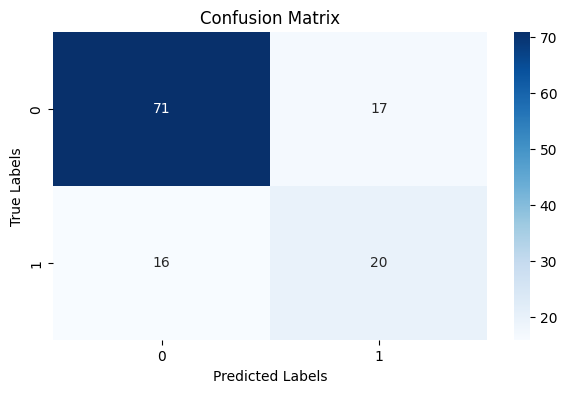

Epoch [47/50], Train Loss: 0.0115, Validation Loss: 0.8872, Accuracy: 73.39%


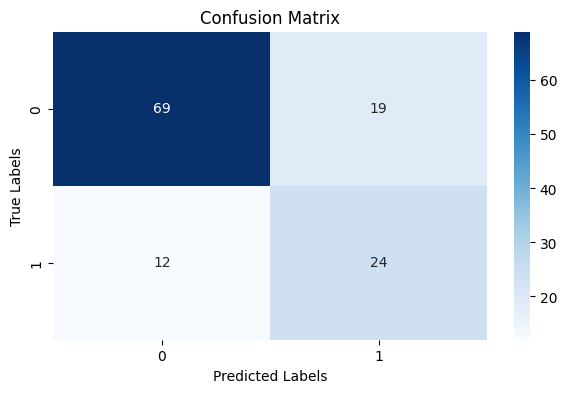

Epoch [48/50], Train Loss: 0.0170, Validation Loss: 0.9473, Accuracy: 75.00%


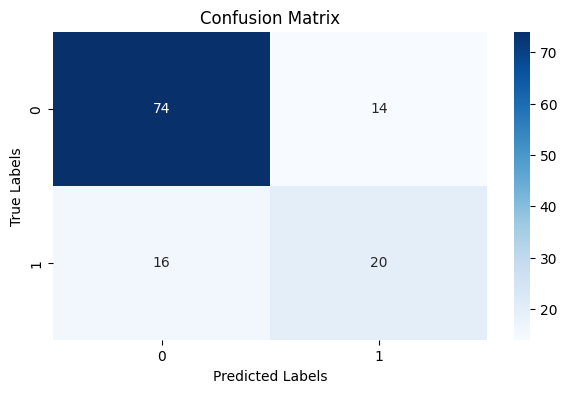

Epoch [49/50], Train Loss: 0.0295, Validation Loss: 0.8945, Accuracy: 75.81%


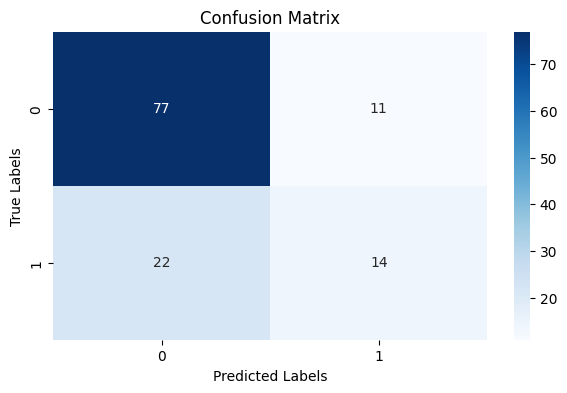

Epoch [50/50], Train Loss: 0.0181, Validation Loss: 0.9123, Accuracy: 73.39%


In [5]:
criterion = torch.nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(filter(lambda p: p.requires_grad, resnet.parameters()), lr=0.00003, weight_decay=1e-3)
num_epochs = 50
for epoch in range(num_epochs):
    resnet.train()
    train_loss = 0
    for images, labels in train_loader:
        #print('iter')
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = resnet(images)
        loss = criterion(outputs, labels.float().view(-1, 1))
        loss.backward()
        optimizer.step()
        train_loss += loss.item()

    # Calculando la pérdida promedio en la época
    train_loss /= len(train_loader)

    # Evaluación con el conjunto de validación/test
    resnet.eval()
    validation_loss = 0
    correct = 0
    total = 0
    all_predicted = []
    all_labels = []
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = resnet(images)
            labels = labels.float().view(-1, 1)
            loss = criterion(outputs, labels)
            validation_loss += loss.item()
            predicted = torch.sigmoid(outputs).ge(0.5).float()  # ge es 'greater or equal'
            total += labels.size(0)
            correct += (predicted == labels).float().sum().item()  # Asegura que la suma se haga sobre floats
            all_predicted.append(predicted.cpu().numpy())
            all_labels.append(labels.cpu().numpy())

    validation_loss /= len(test_loader)
    accuracy = 100 * correct / total

    all_predicted = np.concatenate(all_predicted)
    all_labels = np.concatenate(all_labels)
    
    # Calculando la matriz de confusión
    conf_matrix = confusion_matrix(all_labels, all_predicted)
    plt.figure(figsize=(7,4))
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.title('Confusion Matrix')
    plt.show()

    print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_loss:.4f}, Validation Loss: {validation_loss:.4f}, Accuracy: {accuracy:.2f}%')

In [6]:
print((predicted == labels))

tensor([[False],
        [ True],
        [False],
        [False],
        [ True],
        [ True],
        [ True],
        [False],
        [False],
        [ True],
        [ True],
        [ True]], device='cuda:0')
